In [12]:
import re
from nltk.stem import PorterStemmer 
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt


**Instructions:**

1. Make sure you submit the solutions before the deadline (**Wednesday Wed. 13, 2024 by midnight**). Late submission will be penalized as follows: late within one day (24 hours): 15% penalty; late within two days: 30% penalty, late within three days: 40% penalty. Submission after three days will not be accepted.

2. Discussion with classmates on the problems is not allowed. All clarification questions should be directed to me. You should be responsible for the debugging of the code.

3. Make sure you rerun the whole Jupyter file one last time before submission. The cell numbers should be consecutive starting from 1.

4. After you submit your code, it is your responsibility to check if you submitted the correct file. Sometimes an empty file is submitted by mistake. I will treat any resubmissions past the deadline that are due to such mistakes as late submissions.

5. Please utilize the time wisely. Do not wait until the last few days to start working on the project.

Good luck!

# Midterm Project-Building a Spam Filter

The purpose of this project is to train a classifier to detect email spams (spam $y=1$, non-spam $y=0$).

First, we need to change any text email to numerical values (a feature vector $\boldsymbol{x}\in\mathbb{R}^n$). We walk through the steps of constructing such a vector from an email.

## Preprocessing Emails (20 pts)

The file named "email1.txt" contains an example email that contains words, numbers, an email address, a URL, special letters (e.g. the dollar sign). Since many emails may contain numbers, email addresses, URLs, special letters, it is common practice to "normalize" these values, so that all email addresses, URLs, etc. are treated the same. For example, we can replace any URL with a special string "httpaddress" to indicate a URL exists. The purpose is to let the spam classifier know a URL is present, instead of what the URL is. Following this idea, we will implement the following steps for any raw email:

1. Lower-casing: convert all letters to lower case
2. Normalizing URLs: All URLs are replaced with the text "httpaddr".
3. Normalizing email addresses: Replace all email addresses with the text "emailaddr"
4. Normalizing numbers: Replace all numbers with the text "number".
5. Normalizing Dollars: Replace all dollar signs $\$$ with the text "dollar".
6. Stemming words: For example, "replacing", "replaces", "replaced" are all replaced with "replace"
7. Removing non-words: Remove non-words and punctuations. All white spaces (tabs, newlines ('\n'), spaces) should be trimmed to a single space character.

To achieve all the 7 steps, we look at an example. Read in "email1.txt" as a single string:

In [13]:
email = open('email1.txt', 'r').read()
email

"> Anyone knows how much it costs to host a web portal ?\n>\nWell, it depends on how many visitors you're expecting.\nThis can be anywhere from less than 10 bucks a month to a couple of $100. \nYou should checkout http://www.rackspace.com/ or perhaps Amazon EC2 \nif youre running something big..\n\nTo unsubscribe yourself from this mailing list, send an email to:\ngroupname-unsubscribe@egroups.com\n\n"

Here are the codes to realize all the steps above in Python. Suppose we have a string variable named str1.

1. str1.lower() converts all uppercase characters in str1 into lowercase characters (note that str1 itself does not change.)
2. Replace URLs by: re.sub(r'(http|https)://[^\s]*', 'httpaddr', str1)
3. Replace email addresses by: re.sub('[^\s]+@[^\s]+', 'emailaddr', str1);
4. Replace all numbers by: re.sub('[0-9]+', 'number', str1)
5. Replace dollar sign by: re.sub('[$]+', 'dollar', str1)
6. Word Stemming: first build a PorterStemmer class by: ps = PorterStemmer(), then stemming the words by: 

str1 = " ".join([ps.stem(word) for word in str1.split()])

7. Remove non-words and punctuations by: 

Trim white spaces to a single space character by: re.sub(r'\s+',' ', str1)

Finally strip the string (remove spaces at the beginning and at the end of the string) by:
str1 = str1.strip()

Try each of this steps on the email string, and see if it works (you don't need to show the process). If everything works, then put everything in a function of the following form: 

In [14]:
def ProcessEmail(emailstring):
    """
    Process the 7 steps above for an email string
    input: emailstring: the string that contains the email content. type: string
    return: a string that is the processed email content
    """

    #Step 1: Lower Case
    emailstring = emailstring.lower()

    #Step 2: Replace URLs
    emailstring = re.sub(r'(http|https)://[^\s]*', 'httpaddr', emailstring)

    #Step 3: Replace email address
    emailstring = re.sub('[^\s]+@[^\s]+', 'emailaddr', emailstring)

    #Step 4: Replace all numbers
    emailstring = re.sub('[0-9]+', 'number', emailstring)

    #Step 5: Replace dollar signs
    emailstring = re.sub('[$]+', 'dollar', emailstring)

    #Step 7: Remove non-words and punctuations
    emailstring = re.sub(r'[\'\"@$%/#.:,&*+=?!\[\](){}>_<]', '', emailstring)

    #Step 6: Word Stemming
    ps = PorterStemmer()
    words = emailstring.split()
    stemmed_words = [ps.stem(word) for word in words]
    emailstring = " ".join(stemmed_words)

    return emailstring


Finish the body of the function.

Run the function ProcessEmail for the email string that was read in earlier. If you get the following content, then congratulations, your code works.

anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr

In [15]:
processed_email = ProcessEmail(email)

processed_email == 'anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr'

True

## Vocabulary List (25 pts)

After the emails are preprocessed, we now have a string that contains a list of words for
each email. In the next step, we choose the words we would like to use in our classifier and ignore the rest. Suppose, based on a large number of email samples, we have already chosen the most frequently occuring words as the set of words to be considered, known as the vocabulary list, which is stored in vocab.txt. 

In [16]:
vocab = pd.read_csv('vocab.txt', delim_whitespace=True, names=['index', 'word'])
vocab.head(10)

/var/folders/7h/h3k543j54qggz0d043zhw4mm0000gn/T/ipykernel_48083/2743426039.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  vocab = pd.read_csv('vocab.txt', delim_whitespace=True, names=['index', 'word'])


,index,word
0,1,aa
1,2,ab
2,3,abil
3,4,abl
4,5,about
5,6,abov
6,7,absolut
7,8,abus
8,9,ac
9,10,accept


Each word has an index.

Given the vocabulary list, we can now map each word in the preprocessed emails into a list of indices, each of which is the index of the word in the vocabulary list. Specifically, in the sample email, the word "anyon" can be mapped onto the index 86 in the vocabulary
list. If a word is not in the vocabulary, ignore it. Now write a function in the following form:

In [17]:
def EmailToIndices(processed_email, vocab_df):
    """
    Turn processed email string to a list of indices
    input: processed_email: a string of preprocessed email
           vocab_df: the vocabulary data frame
    return: a list of integers, which are the indices of the words in the vocabulary list
    Hint1: First, you need to turn the email string to a list of words by 
           processed_email.split(); then for each word check if it is in the vocabulary;
           if it is in it, then find the corresponding index and append it to your 
           index list; otherwise ignore it.
    Hint2: To build the list of indices, you can start with an empty list [] and append
           indices one by one as you find them using the append function associated with 
           the list
    Hint3: to check if a word, say "anyon" appears in the "word" column of the vocabulary
           you can use "anyon" in vocab['word'].values, which will give you a True or
           False
    """

    #Split the email into words
    words = processed_email.split()

    #Create an empty list that will contain the indices 
    indices = []

    #Iterate over each word of the email
    for word in words:
        
        #Check if the word exists on vocab_df
        if word in vocab_df['word'].values:
            index = vocab_df[vocab_df['word'] == word]['index'].values[0]
            indices.append(index)
       
    return indices


Test your EmailToIndices function on the preprocessed email string obtained earlier. If you get the following list of integers, congratulations again, your code works.

[86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1895, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]

In [18]:
indices = EmailToIndices(processed_email, vocab)

actual = [86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1895, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]
            
indices == actual

True

## Extracting Features from Emails (25 pts)

Now we will convert each email into a vector in $R^n$ as the features, where $n$ is the number of words in the vocabulary list. Specifically, the feature $x_i=0$ or $1$ for an email depending on whether the $i$-th word in the vocabulary list occurs in the email. That is, $x_i = 1$ if the $i$-th word is in the email and $x_i = 0$ if the i-th word is not present in the email. Write a function that converts a list of indices obtained from the previous function to a feature vector in $R^n$. Follow the following form:

In [19]:
def FeatureExtraction(indices, vocab_df):
    """
    Convert a list of word indices to a feature vector
    input: indices: a list of integer, which are the indices of the words in the email
           vocab_df: the vocabulary data frame
    return: a one-dimensional numpy array that contains the features. The size of the
            array is equal to the number of rows of the vocabulary data frame
    PAY ATTENTION: the index in the vocabulary starts with 1, but for numpy array index
                   starts from 0

    """

    #Create array of zeros with the same size as the vocabulary list
    n = len(vocab_df)
    features = np.zeros(n)

    #Adjust indices of the list of integers 
    adjusted_indices = [index - 1 for index in indices]

    #Set the feature vector to 1 for each word present in the email
    for index in adjusted_indices:

        features[index] = 1
    
    return features


Run the function on the list of indices obtained from the previous problem to get the feature vector. Report the number of nonzeros in the vector and the size of the vector.

In [20]:
features = FeatureExtraction(indices, vocab)
print('Size of the vector =', len(features))
print('Number of nonzeros in vector=', np.count_nonzero(features))

Size of the vector = 1899
Number of nonzeros in vector= 44


## Training SVM for Spam Classification (30 pts)

Now suppose we have preprocessed a bunch of emails and manually labled them. Each original email was processed using the ProcessEmail, EmailToIndices, and FeatureExtraction functions in sequence, and converted into a vector in $R^{1899}$. We use the data to train a Linear SVM classifier. The file "spamTrain.npy" contains 4000 training examples of spam and non-spam email, while "spamTest.npy" contains 1000 test examples. The last column is the target label (spam: y=1, non-spam: y=0). Use np.load(filename) to read in the data.

1. For training the linear SVM, consider $C=\{0.05, 1.0, 2.0\}$. Set random_state=10, loss='hinge', and all the other parameters are by default. For each model report the accuracy on the test data (LinearSVC has a built in function to calculate accuracy). Also report the best model based on the accuracy values.

2. Look at the parameters $\boldsymbol{w}=\{w_1,w_2,\dots,w_n\}$ of the underlying linear model. Make a plot of the absolute values of $\boldsymbol{w}$ versus the indices $[0,1,2,...n-1]$. Are some weights $w_i$ significantly larger than the rest of the weights from the graph? If so, the words corresponding to the larger weights are the most predictive of spam. Find those words. (Hint: you need to find the indices (positions) of the 15 largest values in the vector $\boldsymbol{w}$. The function np.argsort may help. Check the usage of the function. Then use the indices to find the words in the vocabulary data frame.

In [21]:
#Answer to 1

train_data = np.load('spamTrain.npy')
test_data = np.load('spamTest.npy')

# Separate features and labels
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# Define the values of C to consider
C_values = [0.05, 1.0, 2.0]

best_accuracy = 0
best_C = None
best_model = None

# Train Linear SVMs and evaluate accuracy
for C in C_values:
    model = LinearSVC(C=C, random_state=10, loss='hinge', dual = 'auto') #get rid of warning message with dual
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"C={C}: Accuracy = {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C
        best_model = model

print(f"Best Model: C={best_C} with accuracy = {best_accuracy}")



C=0.05: Accuracy = 0.992
C=1.0: Accuracy = 0.977
C=2.0: Accuracy = 0.974
Best Model: C=0.05 with accuracy = 0.992


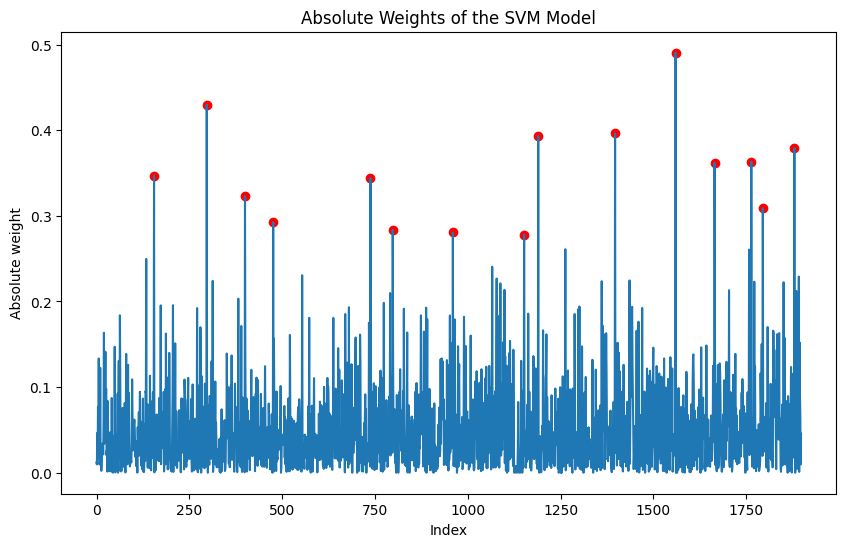

Most Predictive Words of Spam and their Weights:
spamassassin | Weight = 0.4906
click | Weight = 0.4300
remov | Weight = 0.3963
our | Weight = 0.3935
wrote | Weight = 0.3793
url | Weight = 0.3633
the | Weight = 0.3620
basenumb | Weight = 0.3471
guarante | Weight = 0.3441
date | Weight = 0.3230
visit | Weight = 0.3089
dollar | Weight = 0.2926
httpaddr | Weight = 0.2837
list | Weight = 0.2807
numbertnumb | Weight = 0.2782


In [22]:
#Answer to 2

# Analyze the weights of the best model
weights = best_model.coef_[0]
indices = np.arange(len(weights))

# Indices of the 15 largest weights
sorted_indices = np.argsort(np.abs(weights))[-15:][::-1]

# Plot the absolute values of weights
plt.figure(figsize=(10, 6))
plt.plot(indices, np.abs(weights))
plt.scatter(sorted_indices, np.abs(weights)[sorted_indices], color='red')
plt.xlabel('Index')
plt.ylabel('Absolute weight')
plt.title('Absolute Weights of the SVM Model')
plt.show()



# Find the words corresponding to the largest weights
predictive_words = vocab.iloc[sorted_indices]
predictive_weights = np.abs(weights)[sorted_indices]


print("Most Predictive Words of Spam and their Weights:")
for word, weight in zip(predictive_words['word'], predictive_weights):
    print(f"{word} | Weight = {weight:.4f}")

